In [1]:
import os
import sys
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

torch.backends.cudnn.deterministic = True



In [2]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("matplotlib version:", matplotlib.__version__)
print("pandas version:", pd.__version__)
print("PIL version:", PIL.__version__)
print("torch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)

Platform: win32
Python version: 3.13.2 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:49:14) [MSC v.1929 64 bit (AMD64)]
---
matplotlib version: 3.10.0
pandas version: 2.2.3
PIL version: 11.1.0
torch version: 2.7.0+cpu
torchvision version: 0.22.0+cpu


In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cpu device.


# Build a transformer pipeline

In [4]:
class convertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [5]:
transform = transforms.Compose([
      convertToRGB(),
      transforms.Resize((200, 200)),
      transforms.ToTensor()
]
)

In [6]:
os.getcwd()

'C:\\Users\\MonsuratAyinde\\Desktop\\CNN'

In [7]:
data_dir = "safari/"
train_dir = os.path.join(data_dir, "training")

print("Will read data from", train_dir)

Will read data from safari/training


# Load the dataset

In [8]:
dataset = datasets.ImageFolder(root = train_dir, transform = transform)

In [9]:
print("Classes:")
print(dataset.classes)
print(f"That's {len(dataset.classes)} classes")
print()
print("Tensor shape for one image:")
print(dataset[0][0].shape)

Classes:
['elephant', 'giraffe', 'lion', 'zebra']
That's 4 classes

Tensor shape for one image:
torch.Size([3, 200, 200])


# Create a DataLoader that loads from this DataSet in batches of 32.

In [10]:

batch_size = 32
dataset_loader = DataLoader(dataset, batch_size = batch_size)

# get one batch
first_batch = next(iter(dataset_loader))
print(f"Shape of one batch: {first_batch[0].shape}")
print(f"Shape of labels: {first_batch[1].shape}")

Shape of one batch: torch.Size([32, 3, 200, 200])
Shape of labels: torch.Size([32])


# Transform the Data

Our images are all the same shape, and have been converted to tensors. But neural networks tend to perform best with data that has a mean of  
0 and a standard deviation of 1

In [11]:
def get_mean_std(loader):
    channel_sum, channel_squared_sum, num_batches = 0,0,0
    for data, _ in tqdm(loader):
        channel_sum += torch.mean(data, dim=[0, 2, 3])
        channel_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    # Compute the mean from the channels_sum and num_batches
    mean = channel_sum/num_batches
     # Compute the standard deviation form channels_squared_sum, num_batches,
    # and the mean
    std = (channel_squared_sum/num_batches - mean** 2) ** 2
    return mean, std

mean, std = get_mean_std(dataset_loader)

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

  0%|          | 0/13 [00:00<?, ?it/s]

Mean: tensor([0.9348, 0.9227, 0.8904])
Standard deviation: tensor([0.0015, 0.0019, 0.0058])


# Build a new transformer pipeline that normalizes the channels according to the mean and standard deviation above.

In [12]:
transform_norm = transforms.Compose([
    convertToRGB(),
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std)
])

print(transform_norm)




Compose(
    Resize(size=(200, 200), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.9348, 0.9227, 0.8904]), std=tensor([0.0015, 0.0019, 0.0058]))
)


# Make a new normalized dataset using ImageFolder and a new DataLoader

In [13]:
norm_dataset = datasets.ImageFolder(root = train_dir, transform = transform_norm)
norm_loader = DataLoader(dataset = norm_dataset, batch_size = 32)

# Train and validation splitting

Use random_split to create a training dataset with 80% of the data, and a validation dataset with 20% of the data. Remember to use the normalized data

In [14]:
g = torch.Generator()
g.manual_seed(42)

train_dataset, val_dataset = random_split(norm_dataset, [0.8, 0.2])
length_train = len(train_dataset)
length_val = len(val_dataset)
length_dataset= len(norm_dataset)

percent_train = np.round(100 * length_train/length_dataset, 2)
percent_Val = np.round(100 * length_val/length_dataset, 2)

print("Training data set size:", len(train_dataset))
print("Validation data set size:", len(val_dataset))

print(f'the size of train dataset is {percent_train}%, of full data')
print(f'the size of Val dataset is {percent_Val}%, of full data')

Training data set size: 317
Validation data set size: 79
the size of train dataset is 80.05%, of full data
the size of Val dataset is 19.95%, of full data


# Visualize the data with Barchart


In [15]:
def class_counts(dataset_subset):
    c = Counter(x[1] for x in tqdm(dataset_subset))
    class_to_index = dataset_subset.dataset.class_to_idx
    return pd.Series({class_name: c[idx] for class_name, idx in class_to_index.items()})

In [16]:
train_class_distributions = class_counts(train_dataset)

train_class_distributions

  0%|          | 0/317 [00:00<?, ?it/s]

elephant    77
giraffe     76
lion        78
zebra       86
dtype: int64

# Create a bar plot from these counts.

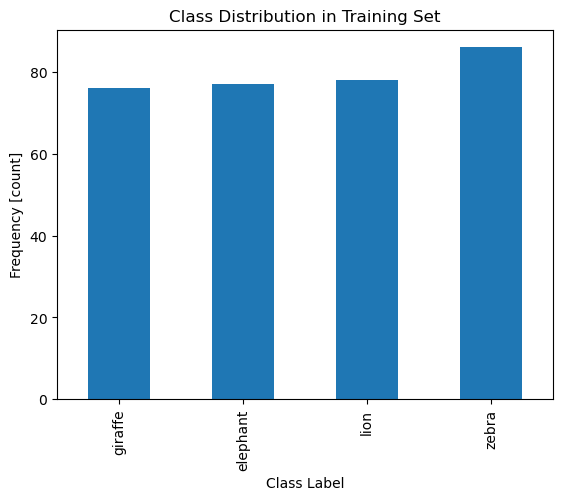

In [17]:
train_class_distributions.sort_values().plot(kind = "bar")

# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Class Distribution in Training Set");

  0%|          | 0/79 [00:00<?, ?it/s]

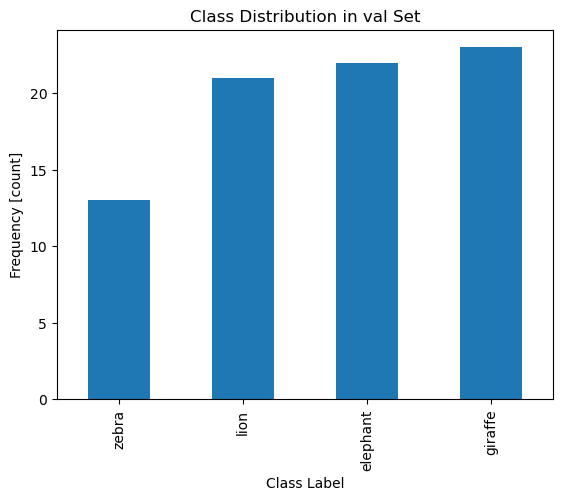

In [18]:
# Get the class distribution
val_class_distributions = class_counts(val_dataset)

# Create a bar plot from train_class_distribution
val_class_distributions.sort_values().plot(kind="bar")

# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Class Distribution in val Set");

# Create data loaders for the train and validation sets. Use a batch size of 32
 

In [19]:
g = torch.Generator()
g.manual_seed(42)

batch_size= 16

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size)

single_batch = next(iter(train_loader))[0]
print(f"Shape of one batch: {single_batch.shape}")

Shape of one batch: torch.Size([16, 3, 200, 200])


# Build the Model

In [20]:
import torch
import torch.nn as nn

model = torch.nn.Sequential()

# First Convolutional Block
conv1 = torch.nn.Conv2d(in_channels=3, out_channels=12, kernel_size=(3, 3), stride=1, padding=1)
max_pool1 = torch.nn.MaxPool2d(kernel_size=(2, 2))  # This reduces 200x200 → 100x100
model.append(conv1)
model.append(torch.nn.ReLU())
model.append(max_pool1)

# Second Convolutional Block
conv2 = torch.nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), stride=1, padding=1)
max_pool2 = torch.nn.MaxPool2d(kernel_size=(2, 2))  # 100x100 → 50x50
model.append(conv2)
model.append(torch.nn.ReLU())
model.append(max_pool2)

# Third Convolutional Block with Dropout2d
conv3 = torch.nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(3, 3), stride=1, padding=1)
model.append(conv3)
model.append(torch.nn.ReLU())
model.append(torch.nn.Dropout2d(p=0.2))  # Applies dropout per channel

# Flatten and Fully Connected Layers
model.append(torch.nn.Flatten())
model.append(torch.nn.Dropout(p=0.5))  # Additional dropout before FC layer

# 24 channels × 50 × 50 from final conv output
linear1 = torch.nn.Linear(in_features=24 * 50 * 50, out_features=4)
model.append(linear1)


Sequential(
  (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Dropout2d(p=0.2, inplace=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=60000, out_features=4, bias=True)
)

In [21]:
height, width = 200, 200
summary(model, input_size=(batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [16, 4]                   --
├─Conv2d: 1-1                            [16, 12, 200, 200]        336
├─ReLU: 1-2                              [16, 12, 200, 200]        --
├─MaxPool2d: 1-3                         [16, 12, 100, 100]        --
├─Conv2d: 1-4                            [16, 12, 100, 100]        1,308
├─ReLU: 1-5                              [16, 12, 100, 100]        --
├─MaxPool2d: 1-6                         [16, 12, 50, 50]          --
├─Conv2d: 1-7                            [16, 24, 50, 50]          2,616
├─ReLU: 1-8                              [16, 24, 50, 50]          --
├─Dropout2d: 1-9                         [16, 24, 50, 50]          --
├─Flatten: 1-10                          [16, 60000]               --
├─Dropout: 1-11                          [16, 60000]               --
├─Linear: 1-12                           [16, 4]                   240,004
Tot

In [22]:
from training import predict, train

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)

Sequential(
  (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Dropout2d(p=0.2, inplace=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=60000, out_features=4, bias=True)
)

# Train model for 8 epochs

In [24]:
# train(model, optimizer, loss_fn, train_loader, test_loader, epochs =8, device=device)

In [25]:
epoch_nums, training_loss, val_loss = train(model, optimizer, loss_fn, train_loader, val_loader, epochs=8, device=device)

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 7.04, Test Loss: 0.02, Test accuracy = 0.99


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 0.04, Test Loss: 0.00, Test accuracy = 1.00


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 0.04, Test Loss: 0.00, Test accuracy = 1.00


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 4, Training Loss: 0.02, Test Loss: 0.00, Test accuracy = 1.00


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 5, Training Loss: 0.00, Test Loss: 0.00, Test accuracy = 1.00


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 6, Training Loss: 0.00, Test Loss: 0.00, Test accuracy = 1.00


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 7, Training Loss: 0.00, Test Loss: 0.00, Test accuracy = 1.00


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 8, Training Loss: 0.00, Test Loss: 0.00, Test accuracy = 1.00


In [26]:
# # Save the model weights
# model_file = 'animal_classifier.pt'
# torch.save(model.state_dict(), model_file)
# del model
# print('model saved as', model_file)

In [27]:
torch.save(model, "model/animal_classifier.pth")

In [28]:
model = torch.load("model/animal_classifier.pth", weights_only=False)

# Evaluate the model performance

# Calculate the predictions for the test set.

In [29]:
probabilities = predict(model, val_loader, device)
predictions = torch.argmax(probabilities, dim=1)

Predicting:   0%|          | 0/5 [00:00<?, ?it/s]

In [30]:
targets = []

for _, labels in tqdm(val_loader):
    targets.extend(labels.tolist())

  0%|          | 0/5 [00:00<?, ?it/s]

In [31]:
targets[:10]

[3, 3, 1, 3, 2, 0, 2, 1, 2, 0]

# View the loss history

 check for overfitting

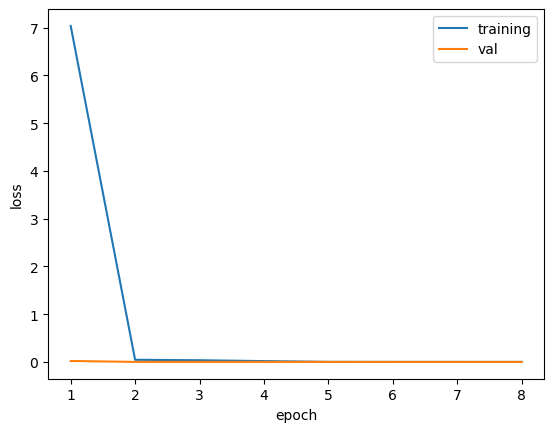

In [32]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, val_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'val'], loc='upper right')
plt.show()

#visualize accuracy

In [33]:
# # Modify your `train()` function to also return test_accuracy_list
# # Then plot:
# plt.plot(epoch_nums, test_accuracies)
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.title("Test Accuracy Over Epochs")
# plt.show()


C:\Users\MonsuratAyinde\AppData\Local\Temp\ipykernel_11712\2264241377.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = torch.tensor(predictions).cpu().numpy()


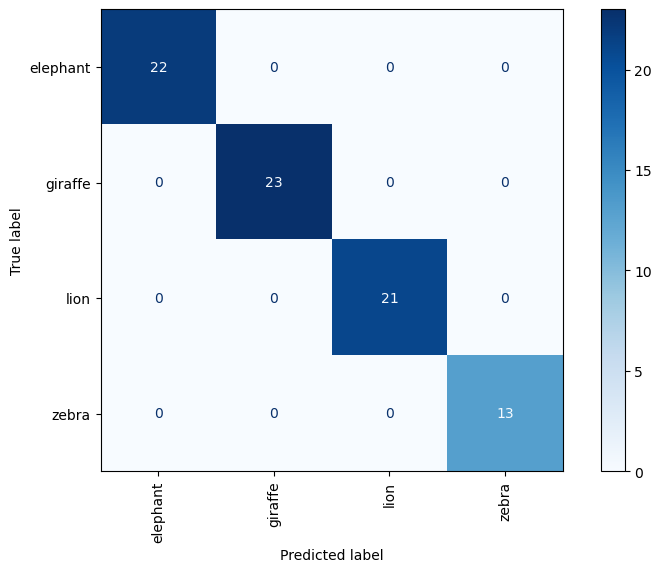

In [34]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# If targets and predictions are lists, convert them to tensors first
y_true = torch.tensor(targets).cpu().numpy()
y_pred = torch.tensor(predictions).cpu().numpy()

# Get the class names from your dataset
classes = train_dataset.dataset.classes  # if you used random_split on an ImageFolder

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(10, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical", ax=ax)
plt.show()


# Create a data set for the test data

In [35]:
data_dir = "safari/"
test_dir = os.path.join(data_dir, "test")

test_dataset = datasets.ImageFolder(root = test_dir, transform = transform_norm) 

print("Number of test images:", len(test_dataset))

test_loader = DataLoader(test_dataset, batch_size = 4)

Number of test images: 4


# make predictions for each of the test image 

In [38]:
# Predict the probabilities for each test image
test_probabilities = predict(model, test_loader, device)

# Get the index associated with the largest probability for each test image
test_predictions = torch.argmax(test_probabilities, dim=1)

print("Number of predictions:", test_predictions.shape)

Predicting:   0%|          | 0/1 [00:00<?, ?it/s]

Number of predictions: torch.Size([4])


# Convert the class index to the class name for each test image.

In [39]:
test_classes = [classes[i] for i in test_predictions]

print("Number of class predictions:", len(test_classes))

Number of class predictions: 4


Predicting:   0%|          | 0/1 [00:00<?, ?it/s]

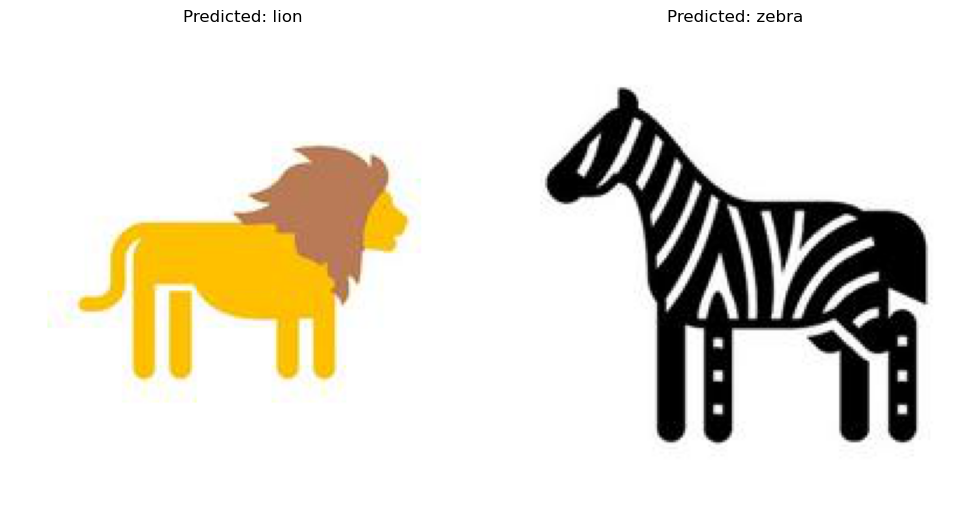

In [43]:
import matplotlib.pyplot as plt
import random
from PIL import Image

# Get predictions for all test images
test_probabilities = predict(model, test_loader, device)
test_predictions = torch.argmax(test_probabilities, dim=1)
test_predictions = test_predictions.cpu().numpy()  # ensure it's a NumPy array

# Sample 2 random indices from the test dataset
sample_indices = random.sample(range(len(test_loader.dataset.samples)), 2)

# Create a 1x2 grid
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Make sure axes is iterable
if not isinstance(axes, (list, np.ndarray)):
    axes = [axes]

# Loop over selected indices and plot images + predictions
for ax, idx in zip(axes, sample_indices):
    image_path = test_loader.dataset.samples[idx][0]
    img = Image.open(image_path)
    
    ax.imshow(img)
    ax.axis('off')
    
    # Use the class label from the dataset
    predicted_class_idx = test_predictions[idx]
    class_name = test_loader.dataset.classes[predicted_class_idx]
    
    ax.set_title(f"Predicted: {class_name}", fontsize=12)

plt.tight_layout()
plt.show()
